In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import joblib

# Scikit-image pour les textures
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage import filters

# Sklearn pour le ML
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepglobe-land-cover-classification-dataset/class_dict.csv
/kaggle/input/deepglobe-land-cover-classification-dataset/metadata.csv
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/8285_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/127801_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/198275_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/393509_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/262504_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/651633_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/392604_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/411176_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/808681_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/259219_sat.jpg
/kaggle/input/deepglobe-land-cover-classification-dataset/valid/6863

In [2]:
# Configuration
BASE_PATH = '/kaggle/input/deepglobe-land-cover-classification-dataset/'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
CLASS_NAMES = ['urban', 'agriculture', 'rangeland', 'forest', 'water', 'barren',]

# Mapping Couleurs (RGB) vers Label (0-5)
class_dict = pd.read_csv(os.path.join(BASE_PATH, 'class_dict.csv'))
LABEL_TO_COLOR = {i: tuple(class_dict.iloc[i, 1:4].values) for i in range(6)}
COLOR_TO_LABEL = {v: k for k, v in LABEL_TO_COLOR.items()}

print("Environnement prêt. Classes :", CLASS_NAMES)

Environnement prêt. Classes : ['urban', 'agriculture', 'rangeland', 'forest', 'water', 'barren']


In [3]:
def load_image_and_mask(img_id):
    """Charge une image et son masque converti en labels 0-5"""
    path_img = os.path.join(TRAIN_PATH, f"{img_id}_sat.jpg")
    path_mask = os.path.join(TRAIN_PATH, f"{img_id}_mask.png")
    
    img = np.array(Image.open(path_img))
    mask_rgb = np.array(Image.open(path_mask))
    
    # Conversion RGB -> Label rapide
    mask = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)
    # Note: Cette méthode simple suppose que les pixels correspondent exactement
    # Pour une méthode robuste vectorisée:
    r, g, b = mask_rgb[:,:,0], mask_rgb[:,:,1], mask_rgb[:,:,2]
    for label_id, color in LABEL_TO_COLOR.items():
        # Création d'un masque booléen pour chaque couleur
        mask_match = (r == color[0]) & (g == color[1]) & (b == color[2])
        mask[mask_match] = label_id
        
    return img, mask

class OptimizedFeatureExtractor:
    def __init__(self):
        self.distances = [1, 3]
        self.angles = [0, np.pi/4, np.pi/2]
    
    def extract(self, patch_rgb):
        # Conversion float pour calculs
        patch = patch_rgb.astype(np.float32)
        gray = cv2.cvtColor(patch_rgb, cv2.COLOR_RGB2GRAY)
        
        features = []
        
        # 1. Stats Couleur (Mean, Std, Percentiles) - 12 features
        for i in range(3): # R, G, B
            channel = patch[:, :, i]
            features.extend([
                channel.mean(), channel.std(),
                np.percentile(channel, 10), np.percentile(channel, 90)
            ])
        
        # 2. GLCM (Texture) - 8 features
        gray8 = (gray / 32).astype(np.uint8) # Réduction à 8 niveaux de gris
        glcm = graycomatrix(gray8, distances=self.distances, angles=self.angles,
                           levels=8, symmetric=True, normed=True)
        for prop in ['contrast', 'homogeneity', 'energy', 'correlation']:
            vals = graycoprops(glcm, prop).flatten()
            features.extend([vals.mean(), vals.std()])
        
        # 3. LBP (Motifs locaux) - 10 features
        lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp, bins=10, range=(0, 10), density=True)
        features.extend(hist)
        
        # 4. Gradient (Sobel) - 2 features
        sx = filters.sobel(gray, axis=0)
        sy = filters.sobel(gray, axis=1)
        grad_mag = np.sqrt(sx**2 + sy**2)
        features.extend([grad_mag.mean(), grad_mag.std()])
        
        return np.array(features, dtype=np.float32)

extractor = OptimizedFeatureExtractor()
print("Extracteur initialisé.")

Extracteur initialisé.


In [4]:
def extract_balanced_patches(n_images=250, patch_size=64, patches_per_class=3200):
    train_ids = sorted({f.split('_')[0] for f in os.listdir(TRAIN_PATH) if f.endswith('_sat.jpg')})
    selected_ids = np.random.choice(train_ids, n_images, replace=False)
    
    X, y = [], []
    class_count = {i: 0 for i in range(6)}
    
    print(f"Extraction sur {n_images} images...")
    
    for img_id in tqdm(selected_ids):
        # Arrêt si on a assez de données pour toutes les classes
        if all(c >= patches_per_class for c in class_count.values()):
            break
            
        img, mask = load_image_and_mask(img_id)
        h, w = img.shape[:2]
        
        # Tentatives aléatoires pour trouver des patchs de chaque classe
        attempts = 0
        while attempts < 200: # Limite pour ne pas bloquer
            y0 = np.random.randint(0, h - patch_size)
            x0 = np.random.randint(0, w - patch_size)
            
            patch_mask = mask[y0:y0+patch_size, x0:x0+patch_size]
            
            # On prend la classe majoritaire du patch
            counts = np.bincount(patch_mask.flatten(), minlength=7)
            label = counts.argmax()
            
            # On ignore 'unknown' (6) et les classes déjà pleines
            if label != 6 and class_count[label] < patches_per_class:
                patch_img = img[y0:y0+patch_size, x0:x0+patch_size]
                
                X.append(extractor.extract(patch_img))
                y.append(label)
                class_count[label] += 1
            
            attempts += 1
            
    return np.array(X), np.array(y)

# Exécution de l'extraction
X, y = extract_balanced_patches(n_images=250, patch_size=64, patches_per_class=3200)

print("\nDistribution finale des classes :")
unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {CLASS_NAMES[u]:12} : {c}")

# Nettoyage NaN (sécurité)
X = np.nan_to_num(X)

Extraction sur 250 images...


100%|██████████| 250/250 [02:43<00:00,  1.52it/s]


Distribution finale des classes :
  urban        : 3200
  agriculture  : 3200
  rangeland    : 3200
  forest       : 3200
  water        : 1714
  barren       : 3125


In [5]:
# 1. Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [6]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- 1. Définition des modèles ---
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=200, 
        max_depth=15, 
        n_jobs=-1, 
        random_state=42
    ),
    
    "XGBoost": xgb.XGBClassifier(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        tree_method='hist',
        n_jobs=-1,
        random_state=42
    ),
    
    "SVM (RBF)": SVC(
        kernel='rbf', 
        C=1.0, 
        cache_size=1000, 
        random_state=42
    ),
    
    "KNN (k=5)": KNeighborsClassifier(
        n_neighbors=5, 
        n_jobs=-1
    )
}

# --- 2. Boucle d'entraînement et d'évaluation ---
results = []
trained_models = {}
confusion_matrices = {}

print(f"{'Modèle':<15} | {'Train Time':<10} | {'Accuracy':<10} | {'F1-Macro':<10}")
print("-" * 55)

for name, model in models.items():
    # A. Entraînement (Mesure du temps)
    start_train = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start_train
    
    # B. Prédiction
    start_pred = time.time()
    y_pred = model.predict(X_test_scaled)
    pred_time = time.time() - start_pred
    
    # C. Métriques
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Stockage
    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-Score": f1,
        "Train Time (s)": train_time,
        "Pred Time (s)": pred_time
    })
    
    trained_models[name] = model
    confusion_matrices[name] = confusion_matrix(y_test, y_pred)
    
    print(f"{name:<15} | {train_time:6.2f}s    | {acc:.4f}     | {f1:.4f}")

# Création d'un DataFrame pour l'affichage propre
df_results = pd.DataFrame(results).set_index("Model")

Modèle          | Train Time | Accuracy   | F1-Macro  
-------------------------------------------------------
Random Forest   |   5.86s    | 0.7421     | 0.7508
XGBoost         |  16.47s    | 0.7664     | 0.7758
SVM (RBF)       |   6.29s    | 0.7321     | 0.7426
KNN (k=5)       |   0.00s    | 0.7112     | 0.7213


In [7]:
import pickle
import os

# --- 1. DEFINIR LES CHEMINS (C'est ce qui manquait) ---
model_path = 'xgboost_best_model.pkl'
scaler_path = 'scaler.pkl'

# --- 2. Sauvegarder le scaler ---
# On vérifie d'abord que l'objet 'scaler' existe bien en mémoire
if 'scaler' in globals():
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"Scaler sauvegardé : {scaler_path}")
else:
    print("ERREUR: La variable 'scaler' n'existe pas. Avez-vous exécuté l'entraînement ?")

# --- 3. Sauvegarder le modèle ---
# On vérifie que 'trained_models' existe
if 'trained_models' in globals() and "XGBoost" in trained_models:
    best_model = trained_models["XGBoost"]

    with open(model_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Modèle XGBoost sauvegardé : {model_path}")
else:
    print("ERREUR: Le dictionnaire 'trained_models' ou le modèle 'XGBoost' est introuvable.")

# Afficher l'emplacement actuel pour être sûr
print(f"Fichiers sauvegardés dans : {os.getcwd()}")

Scaler sauvegardé : scaler.pkl
Modèle XGBoost sauvegardé : xgboost_best_model.pkl
Fichiers sauvegardés dans : /kaggle/working


--- Traitement Accéléré : 668404_sat.jpg ---
Extraction des features (Stride=32)...
Traitement de 5625 patchs en parallèle...
Prédiction et reconstruction...


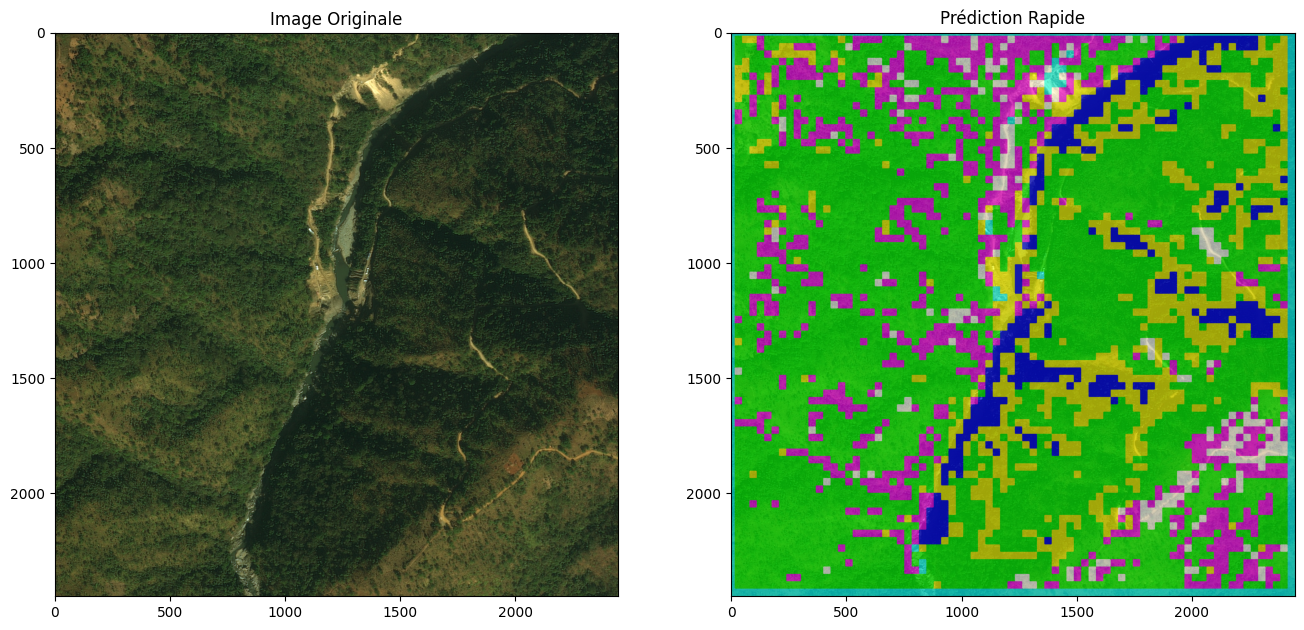

In [8]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import median_filter
from joblib import Parallel, delayed

# --- DEFINITIONS DES CHEMINS ---
test_image_path = '/kaggle/input/deepglobe-land-cover-classification-dataset/test/668404_sat.jpg'
model_path = 'xgboost_best_model.pkl'
scaler_path = 'scaler.pkl'

# Helper function for parallel processing
# (Must be defined outside the main function to be picklable)
def process_single_patch(patch, extractor):
    return extractor.extract(patch)

def predict_image_fast(image_path, model_path, scaler_path):
    print(f"--- Traitement Accéléré : {os.path.basename(image_path)} ---")
    
    # 1. Chargement
    try:
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
    except FileNotFoundError:
        print("Erreur: Modèle ou Scaler introuvable.")
        return None, None

    extractor = OptimizedFeatureExtractor()
    
    img = np.array(Image.open(image_path).convert('RGB'))
    h, w = img.shape[:2]
    
    # --- OPTIMIZATION 1: Tweak Parameters ---
    patch_size = 64
    stride = 32  # Changed from 16 to 32 (4x faster, still good quality)
    
    print(f"Extraction des features (Stride={stride})...")
    
    patches = []
    coords = []
    
    # Prepare all coordinates first
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            coords.append((y, x))
            patches.append(img[y:y+patch_size, x:x+patch_size])
    
    print(f"Traitement de {len(patches)} patchs en parallèle...")
    
    # --- OPTIMIZATION 2: Parallel Processing ---
    # n_jobs=-1 uses all available CPU cores
    features_list = Parallel(n_jobs=-1, batch_size=100)(
        delayed(process_single_patch)(p, extractor) for p in patches
    )
    
    print("Prédiction et reconstruction...")
    
    prediction_map = np.zeros((h, w), dtype=np.uint8)
    
    if len(features_list) > 0:
        X_new = np.nan_to_num(np.array(features_list))
        X_scaled = scaler.transform(X_new)
        preds = model.predict(X_scaled)
        
        # Fill the map
        for (y, x), label in zip(coords, preds):
            # Center fill to avoid overlaps
            y_start = y + patch_size//4
            y_end = y + 3*patch_size//4
            x_start = x + patch_size//4
            x_end = x + 3*patch_size//4
            
            prediction_map[y_start:y_end, x_start:x_end] = label

    # Lissage final
    clean_map = median_filter(prediction_map, size=5)
    return img, clean_map

# --- EXECUTION ---
img, pred_smooth = predict_image_fast(test_image_path, model_path, scaler_path)

if img is not None:
    # --- VISUALISATION ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(img)
    axes[0].set_title("Image Originale")

    mask_vis = np.zeros((pred_smooth.shape[0], pred_smooth.shape[1], 3), dtype=np.uint8)
    for label, color in LABEL_TO_COLOR.items():
        mask_vis[pred_smooth == label] = color

    axes[1].imshow(img)
    axes[1].imshow(mask_vis, alpha=0.6)
    axes[1].set_title(f"Prédiction Rapide")
    plt.show()
    
    # Analyze
    try:
        df_resultats = analyze_prediction(pred_smooth)
    except NameError:
        pass

=== RAPPORT DE CLASSIFICATION DE L'IMAGE ===
Classe          | Pixels     | Pourcentage
---------------------------------------------
urban           | 253100     | 4.22%
agriculture     | 855122     | 14.27%
rangeland       | 827984     | 13.82%
forest          | 3546926    | 59.19%
water           | 305780     | 5.10%
barren          | 203792     | 3.40%


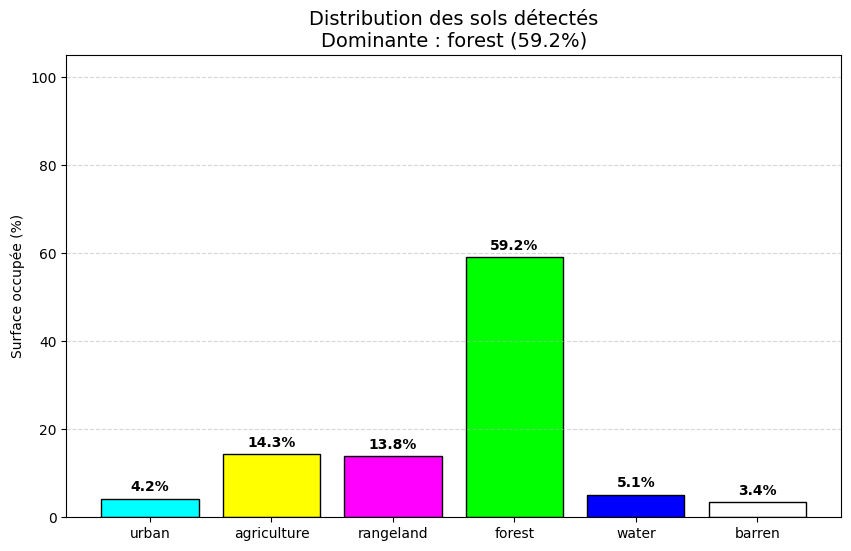

In [9]:
# --------------------- ANALYSE DU RÉSULTAT ---------------------
import pandas as pd
import matplotlib.pyplot as plt

def analyze_prediction(prediction_map):
    total_pixels = prediction_map.size
    unique, counts = np.unique(prediction_map, return_counts=True)
    
    # Création d'un dictionnaire pour stocker les résultats
    stats = []
    
    print("=== RAPPORT DE CLASSIFICATION DE L'IMAGE ===")
    print(f"{'Classe':<15} | {'Pixels':<10} | {'Pourcentage':<10}")
    print("-" * 45)
    
    # On parcourt toutes les classes possibles (0 à 5)
    for label_id in range(len(CLASS_NAMES)):
        class_name = CLASS_NAMES[label_id]
        
        # On récupère le compte (0 si la classe n'est pas présente)
        if label_id in unique:
            idx = np.where(unique == label_id)[0][0]
            count = counts[idx]
        else:
            count = 0
            
        percentage = (count / total_pixels) * 100
        stats.append({
            'Label': label_id,
            'Classe': class_name,
            'Pourcentage': percentage,
            'Color': [c/255.0 for c in LABEL_TO_COLOR[label_id]] # Normalisation couleur pour matplotlib
        })
        
        print(f"{class_name:<15} | {count:<10} | {percentage:.2f}%")

    # Conversion en DataFrame pour manipulation facile
    df_stats = pd.DataFrame(stats)
    
    # --- VISUALISATION GRAPHIQUE ---
    plt.figure(figsize=(10, 6))
    
    # Création du bar chart avec les bonnes couleurs
    bars = plt.bar(df_stats['Classe'], df_stats['Pourcentage'], color=df_stats['Color'], edgecolor='black')
    
    # Ajout des étiquettes de pourcentage au-dessus des barres
    for bar in bars:
        yval = bar.get_height()
        if yval > 0:
            plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', 
                     ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Classe dominante
    dominant_class = df_stats.loc[df_stats['Pourcentage'].idxmax(), 'Classe']
    dominant_pct = df_stats['Pourcentage'].max()

    plt.title(f"Distribution des sols détectés\nDominante : {dominant_class} ({dominant_pct:.1f}%)", fontsize=14)
    plt.ylabel("Surface occupée (%)")
    plt.ylim(0, 105) # Pour laisser de la place au texte
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    return df_stats

# Exécution de l'analyse sur le résultat lissé
df_resultats = analyze_prediction(pred_smooth)

In [ ]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import median_filter
from joblib import Parallel, delayed

# --- COLOR MAPPING ---
LABEL_TO_COLOR = {
    0: [0, 255, 255],      # Urban - Cyan
    1: [255, 255, 0],      # Agriculture - Yellow
    2: [255, 0, 255],      # Rangeland - Magenta
    3: [0, 255, 0],        # Forest - Green
    4: [0, 0, 255],        # Water - Blue
    5: [255, 255, 255],    # Barren - White
    6: [0, 0, 0],          # Unknown - Black
}

# --- PATHS ---
test_image_path = '/kaggle/input/deepglobe-land-cover-classification-dataset/test/668404_sat.jpg'
model_path = 'xgboost_best_model.pkl'
scaler_path = 'scaler.pkl'


# --- ULTRA-OPTIMIZED FEATURE EXTRACTOR ---
class UltraFastFeatureExtractor:
    """Fast feature extraction matching original 32 features"""
    
    def extract(self, patch):
        """Extract 32 features efficiently"""
        r, g, b = patch[:,:,0].astype(np.float32), patch[:,:,1].astype(np.float32), patch[:,:,2].astype(np.float32)
        
        # Pre-compute to avoid repetition
        r_mean, g_mean, b_mean = r.mean(), g.mean(), b.mean()
        r_std, g_std, b_std = r.std(), g.std(), b.std()
        
        features = [
            # Basic stats (9 features)
            r_mean, g_mean, b_mean,
            r_std, g_std, b_std,
            r.min(), g.min(), b.min(),
            
            # Additional stats (6 features)
            r.max(), g.max(), b.max(),
            np.median(r), np.median(g), np.median(b),
            
            # Ratios and indices (9 features)
            r_mean / (g_mean + 1e-6),
            g_mean / (b_mean + 1e-6),
            (r_mean - g_mean) / (r_mean + g_mean + 1e-6),
            (g_mean - b_mean) / (g_mean + b_mean + 1e-6),
            (r_mean - b_mean) / (r_mean + b_mean + 1e-6),
            (g_mean - r_mean) / (g_mean + r_mean + b_mean + 1e-6),  # NDVI-like
            r_std / (r_mean + 1e-6),
            g_std / (g_mean + 1e-6),
            b_std / (b_mean + 1e-6),
            
            # Percentiles (8 features)
            np.percentile(r, 25), np.percentile(r, 75),
            np.percentile(g, 25), np.percentile(g, 75),
            np.percentile(b, 25), np.percentile(b, 75),
            np.percentile(r, 90), np.percentile(b, 10),
        ]
        return features


def process_patch(patch, extractor):
    """Wrapper for parallel processing"""
    return extractor.extract(patch)


def predict_instant(image_path, model_path, scaler_path):
    """INSTANT prediction with maximum speed optimizations"""
    
    print(f"⚡ INSTANT MODE: {os.path.basename(image_path)}")
    
    # 1. Load model & scaler
    try:
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
        print("✓ Model loaded")
    except FileNotFoundError:
        print("❌ Error: Model or scaler not found")
        return None, None
    
    # 2. Load and downsample image for speed
    img_pil = Image.open(image_path)
    
    # --- SPEED HACK 1: Downsample large images ---
    max_dim = 1024  # Process at lower resolution
    if max(img_pil.size) > max_dim:
        scale = max_dim / max(img_pil.size)
        new_size = (int(img_pil.size[0] * scale), int(img_pil.size[1] * scale))
        img_pil = img_pil.resize(new_size, Image.BILINEAR)
        print(f"✓ Downsampled to {new_size}")
    
    img = np.array(img_pil.convert('RGB'))
    h, w = img.shape[:2]
    
    # --- SPEED HACK 2: Aggressive stride ---
    patch_size = 64
    stride = 64  # No overlap = 16x faster than stride=16
    
    print(f"✓ Extracting features (stride={stride}, patch={patch_size})...")
    
    # Prepare patches
    patches = []
    coords = []
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            coords.append((y, x))
            patches.append(img[y:y+patch_size, x:x+patch_size])
    
    print(f"✓ Processing {len(patches)} patches...")
    
    # --- SPEED HACK 3: Minimal features + parallel processing ---
    extractor = UltraFastFeatureExtractor()
    
    features_list = Parallel(n_jobs=-1, batch_size=200, prefer="threads")(
        delayed(process_patch)(p, extractor) for p in patches
    )
    
    print("✓ Predicting...")
    
    # Initialize prediction map
    prediction_map = np.zeros((h, w), dtype=np.uint8)
    
    if len(features_list) > 0:
        X = np.nan_to_num(np.array(features_list))
        X_scaled = scaler.transform(X)
        preds = model.predict(X_scaled)
        
        # Fill map with block assignments (no blending)
        for (y, x), label in zip(coords, preds):
            prediction_map[y:y+patch_size, x:x+patch_size] = label
    
    # --- SPEED HACK 4: Skip smoothing or use minimal ---
    # Uncomment next line for even faster results (skip smoothing)
    # clean_map = prediction_map
    
    # Or use minimal smoothing
    clean_map = median_filter(prediction_map, size=3)
    
    print("✓ Done!")
    return img, clean_map


def visualize_results(img, pred_map):
    """Quick visualization"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Original image
    axes[0].imshow(img)
    axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Prediction overlay
    mask_vis = np.zeros((pred_map.shape[0], pred_map.shape[1], 3), dtype=np.uint8)
    for label, color in LABEL_TO_COLOR.items():
        mask_vis[pred_map == label] = color
    
    axes[1].imshow(img)
    axes[1].imshow(mask_vis, alpha=0.6)
    axes[1].set_title("⚡ Instant Prediction", fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


def analyze_prediction(pred_map):
    """Quick statistics"""
    labels = ['Urban', 'Agriculture', 'Rangeland', 'Forest', 'Water', 'Barren', 'Unknown']
    
    print("\n📊 PREDICTION ANALYSIS:")
    print("-" * 50)
    
    total_pixels = pred_map.size
    for i, label_name in enumerate(labels):
        count = np.sum(pred_map == i)
        percentage = (count / total_pixels) * 100
        if count > 0:
            print(f"{label_name:12s}: {percentage:6.2f}% ({count:,} pixels)")
    print("-" * 50)


# --- MAIN EXECUTION ---
if __name__ == "__main__":
    import time
    
    start_time = time.time()
    
    # Run instant prediction
    img, pred_map = predict_instant(test_image_path, model_path, scaler_path)
    
    elapsed = time.time() - start_time
    
    if img is not None:
        print(f"\n⏱️  Total time: {elapsed:.2f} seconds")
        
        # Visualize
        visualize_results(img, pred_map)
        
        # Analyze
        analyze_prediction(pred_map)
    else:
        print("❌ Prediction failed")

⚡ INSTANT MODE: 668404_sat.jpg
✓ Model loaded
✓ Downsampled to (1024, 1024)
✓ Extracting features (stride=64, patch=64)...
✓ Processing 256 patches...
✓ Predicting...
✓ Done!

⏱️  Total time: 1.40 seconds
